In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
import random

## EVEN-MANSOUR

In [3]:
def even_mansour_circ(em):
    em.h(0)
    em.h(1)
    em.barrier()
    em.cx(0,2)
    em.cx(1,3)
    em.cx(1,2)
    em.cx(0,3)
    em.barrier()
    em.measure(2,2)
    em.measure(3,3)
    em.barrier()
    em.h(0)
    em.h(1)
    em.barrier()
    em.measure(0,0)
    em.measure(1,1)

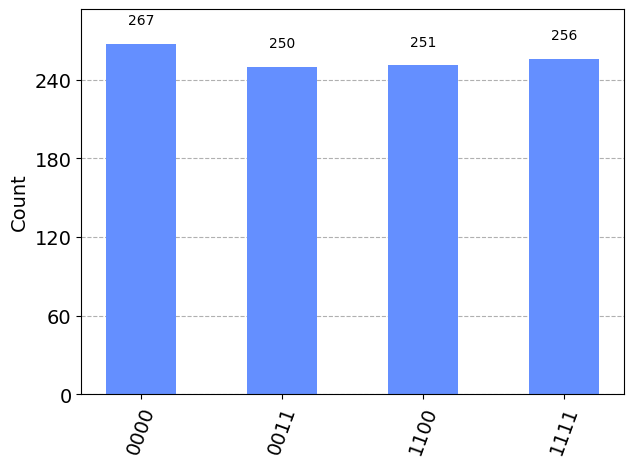

In [4]:
even_mansour = QuantumCircuit(4,4)
even_mansour_circ(even_mansour)
even_mansour.draw('mpl').savefig('emc')
aer_sim = Aer.get_backend('aer_simulator')
t_even_mansour = transpile(even_mansour, aer_sim)
counts_even_mansour = aer_sim.run(t_even_mansour).result().get_counts()
plot_histogram(counts_even_mansour).savefig('even_mansour')
plot_histogram(counts_even_mansour)


The output of first two qubits is either 00 or 11 therefore, if the key is 'ab' then $$a+b = 0 $$
$$ \implies ab = 00 \text{ or } 11 $$ but it is periodic with non-zero period therefore, period $ s = 1$

### RSA

In [10]:
def modular_15_multiplication(a, r):
    U = QuantumCircuit(4)
    for _ in range(r):
        if a in [2,13]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [7,8]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = f"{a}^{r} mod 15"
    control_U = U.control()
    return control_U

In [11]:
def inverse_qft(n):
    """Computes inverse quantum fourier transform of n qubits"""
    iqft = QuantumCircuit(n)
    
    for qubit in range(n//2):
        iqft.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            iqft.cp(-np.pi/float(2**(j-m)), m, j)
        iqft.h(j)
    iqft.name = "Inverse Quantum Fourier Transform"
    return iqft

In [13]:
a = 7
qc = QuantumCircuit(12, 8)


for q in range(8):
    qc.h(q)
qc.x(8)

for q in range(8):
    qc.append(modular_15_multiplication(a, 2**q),
             [q] + [i+8 for i in range(4)])


qc.append(inverse_qft(8), range(8))


qc.measure(range(8), range(8))
qc.draw('mpl').savefig('RSA.png')

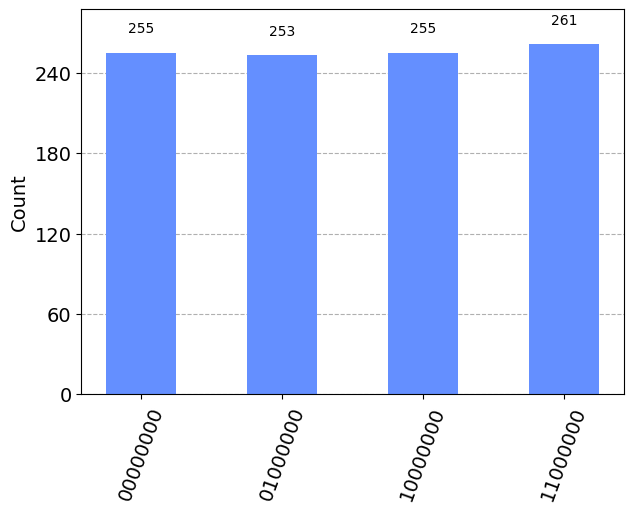

In [14]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
counts = aer_sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [15]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**8)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)",
                 f"{decimal}/{2**8} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output           Phase
0  00000000(bin) =   0(dec)    0/256 = 0.00
1  11000000(bin) = 192(dec)  192/256 = 0.75
2  01000000(bin) =  64(dec)   64/256 = 0.25
3  10000000(bin) = 128(dec)  128/256 = 0.50


In [16]:
def quantum_phase_estimation(a):
    N_qubits = 8
    qc = QuantumCircuit(4+N_qubits, N_qubits)
    for q in range(N_qubits):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+N_qubits) # And auxiliary register in state |1>
    for q in range(N_qubits): # Do controlled-U operations
        
        qc.append(modular_15_multiplication(a, 2**q),
                 [q] + [i+N_qubits for i in range(4)])
    qc.append(inverse_qft(N_qubits), range(N_qubits)) # Do inverse-QFT
    qc.measure(range(N_qubits), range(N_qubits))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # `memory=True` tells the backend to save each measurement in a list
    job = aer_sim.run(transpile(qc, aer_sim), shots=1, memory=True)
    readings = job.result().get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**N_qubits)
    print(f"Corresponding Phase: {phase}")
    return phase

In [18]:
a = 3
N = 15
FACTOR_FOUND = False
ATTEMPT = 0
while not FACTOR_FOUND:
    if a in [3,5,6,9,12]:
        print(str(gcd(a,15))+" is a factor of 15")
    if a in [1,14]:
        raise ValueError("'a' must not be 1,14")
    ATTEMPT += 1
    print(f"\nATTEMPT {ATTEMPT}:")
    phase = quantum_phase_estimation(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator
    print(f"Result: r = {r}")
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print(f"Guessed Factors: {guesses[0]} and {guesses[1]}")
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0:
                # Guess is a factor!
                print("*** Non-trivial factor found: {guess} ***")
                FACTOR_FOUND = True


ATTEMPT 1:
Register Reading: 00000000
Corresponding Phase: 0.0
Result: r = 1

ATTEMPT 2:
Register Reading: 01000000
Corresponding Phase: 0.25
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: {guess} ***
*** Non-trivial factor found: {guess} ***
